In [1]:
from loica import *
import matplotlib.pyplot as plt
import getpass

In [2]:
from flapjack import *
#fj = Flapjack(url_base='flapjack.rudge-lab.org:8000')
fj = Flapjack(url_base='localhost:8000')
fj.log_in(username=input('Flapjack username: '), password=getpass.getpass('Password: '))

Flapjack username: tim
Password: ········


In [3]:
study = fj.create('study', name='Loica testing', description='Test study for demonstrating Loica')

One or more study already exists, type "yes" to replace them:


In [4]:
sfp = fj.create('signal', name='SFP', color='green', description='Simulated fluorescent protein')

One or more signal already exists, type "yes" to replace them:


In [5]:
dna = fj.create('dna', name='band_detect')
vector = fj.create('vector', name='band_detect', dnas=dna.id)

One or more dna already exists, type "yes" to replace them:
One or more vector already exists, type "yes" to replace them:


In [15]:
network = GeneticNetwork(vector=vector.id[0])

regs = [Regulator(f'Rep{i}', degradation_rate=1) for i in range(3)]
ahl = Supplement(name='AHL1')
reporter = Reporter(name='SFP', color='green', signal_id=sfp.id[0])

rec1= Receiver(ahl, regs[0], alpha=[0,10], K=1, n=2)
rec2 = Receiver(ahl, regs[1], alpha=[0,50], K=1, n=2)
not_ = Hill1(regs[1], regs[2], alpha=[50,0], K=1, n=2)
nor = Hill2([regs[0],regs[2]], reporter, alpha=[1,0,0,0], K=[1,1], n=[2,2])

network.add_regulators(regs)
network.add_operators([rec1,rec2,not_,nor])
network.add_reporter(reporter)

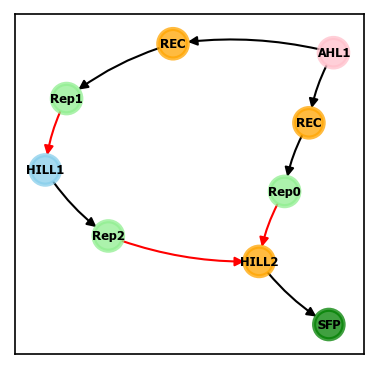

In [16]:
plt.figure(figsize=(3,3), dpi=150)
network.draw(arrowsize=9)

In [17]:
def growth_rate(t):
    return gompertz_growth_rate(t, 0.05, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.05, 1, 1, 1)
    
metab = SimulatedMetabolism(biomass, growth_rate)

media = fj.create('media', name='loica', description='Simulated loica media')
strain = fj.create('strain', name='loica', description='Loica test strain')

One or more media already exists, type "yes" to replace them:
One or more strain already exists, type "yes" to replace them:


In [18]:
# Create list of samples    
samples = []
concs = np.append(0, np.logspace(-2, 2, 24))
for conc in concs:
    for _ in range(1):
        sample = Sample(genetic_network=network, 
                    metabolism=metab,
                    media=media.id[0],
                    strain=strain.id[0])
        # Add AHL to samples at given concentration
        sample.add_supplement(ahl, conc)
        samples.append(sample)

In [19]:
biomass_signal = fj.create('signal', name='SOD', description='Simulated OD', color='black')
assay = Assay(samples, 
              n_measurements=100, 
              interval=0.24,
              name='Loica band detect',
              description='Simulated band detect generated by loica',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

One or more signal already exists, type "yes" to replace them:


100%|███████████████████████████████████████████████████████████| 100.0/100 [00:13<00:00,  7.69it/s]


In [20]:
assay.upload(fj, study.id[0])

One or more assay already exists, type "yes" to replace them:yes


100%|███████████████████████████████████████████████████████████| 100.0/100 [00:17<00:00,  5.82it/s]


In [21]:
ahl1_id = fj.get('chemical', name='AHL1').id[0]
fig = fj.plot(study=study.id,                     
                vector=vector.id,
                signal=sfp.id,
                type='Induction Curve',
                analyte=ahl1_id,
                function='Mean Expression',
                biomass_signal=biomass_signal.id[0],
                normalize='None',
                subplots='Signal',
                markers='Vector',
                plot='All data points'
       )
fig

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 101.47it/s]
